In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
master_data_path = '../data/processed/master_aqi_merged_data.csv'

In [3]:
# Load the master merged data
try:
    master_df = pd.read_csv(master_data_path, parse_dates=['date'])
    print("Master merged data loaded successfully.")
    print(f"Shape: {master_df.shape}")
except FileNotFoundError:
    print(f"Error: Master data file not found at {master_data_path}")
    print("Please run the merging script/notebook (03_Merge_S5P_CPCB_Data) first.")
    raise
except Exception as e:
    print(f"An error occurred loading the data: {e}")
    raise

Master merged data loaded successfully.
Shape: (28952, 13)


In [4]:
print("\n--- Basic Info ---")
master_df.info()


--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28952 entries, 0 to 28951
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     28952 non-null  datetime64[ns]
 1   NO2_satellite            16153 non-null  float64       
 2   SO2_satellite            16153 non-null  float64       
 3   CO_satellite             16153 non-null  float64       
 4   O3_satellite             16153 non-null  float64       
 5   Aerosol_Index_satellite  16153 non-null  float64       
 6   location                 28952 non-null  object        
 7   PM2.5_ground             14819 non-null  float64       
 8   PM10_ground              14819 non-null  float64       
 9   NO2_ground               14819 non-null  float64       
 10  SO2_ground               14819 non-null  float64       
 11  CO_ground                14819 non-null  float64       
 12  O3_ground   

In [5]:
print("\n--- Master Data Head ---")
print(master_df.head())


--- Master Data Head ---
        date  NO2_satellite  SO2_satellite  CO_satellite  O3_satellite  \
0 2020-01-01       0.000191      -0.000433      0.048550      0.164568   
1 2020-01-02       0.000191      -0.000433      0.048550      0.164568   
2 2020-01-03       0.000143       0.000546      0.041712      0.139937   
3 2020-01-04       0.000143      -0.000315      0.044633      0.137429   
4 2020-01-05       0.000143      -0.000531      0.045669      0.128115   

   Aerosol_Index_satellite            location  PM2.5_ground  PM10_ground  \
0                -1.098919  Anand Vihar, Delhi        367.38       449.58   
1                -1.098919  Anand Vihar, Delhi        360.34       463.33   
2                -1.405038  Anand Vihar, Delhi        394.86       500.24   
3                -1.210190  Anand Vihar, Delhi        204.94       359.77   
4                -0.864201  Anand Vihar, Delhi        186.40       313.40   

   NO2_ground  SO2_ground  CO_ground  O3_ground  
0       54.76   

In [6]:
comparison_pairs = {
    'NO2': ('NO2_satellite', 'NO2_ground'),
    'SO2': ('SO2_satellite', 'SO2_ground'),
    'CO': ('CO_satellite', 'CO_ground'),
    'O3': ('O3_satellite', 'O3_ground'),
    'PM2.5': ('Aerosol_Index_satellite', 'PM2.5_ground'), # Note: Comparing AI to PM2.5
    'PM10': ('Aerosol_Index_satellite', 'PM10_ground') # Note: Comparing AI to PM10
}

In [7]:
print("\n--- Correlation Analysis (Satellite vs. Ground) ---")


--- Correlation Analysis (Satellite vs. Ground) ---


In [12]:
all_cols = [col for pair in comparison_pairs.values() for col in pair]

In [13]:
# Create a list of all columns involved in comparisons
columns_to_correlate = list(dict.fromkeys(all_cols))
print(f"Analyzing correlations for columns: {columns_to_correlate}")

Analyzing correlations for columns: ['NO2_satellite', 'NO2_ground', 'SO2_satellite', 'SO2_ground', 'CO_satellite', 'CO_ground', 'O3_satellite', 'O3_ground', 'Aerosol_Index_satellite', 'PM2.5_ground', 'PM10_ground']


In [14]:
# Calculate the full correlation matrix
correlation_matrix = master_df[columns_to_correlate].corr()

In [15]:
# Extract just the correlations we care about
print("\nCorrelation Coefficients (Satellite vs. Ground):")
correlation_results = {}
for pollutant, (sat_col, gnd_col) in comparison_pairs.items():
    if sat_col in correlation_matrix and gnd_col in correlation_matrix:
        corr_value = correlation_matrix.loc[sat_col, gnd_col]
        print(f"{pollutant} ({sat_col} vs {gnd_col}): {corr_value:.4f}")
        correlation_results[f"{pollutant}_corr"] = corr_value
    else:
        print(f"Could not calculate correlation for {pollutant}. Columns missing.")


Correlation Coefficients (Satellite vs. Ground):
NO2 (NO2_satellite vs NO2_ground): 0.3012
SO2 (SO2_satellite vs SO2_ground): 0.0384
CO (CO_satellite vs CO_ground): 0.3250
O3 (O3_satellite vs O3_ground): 0.1667
PM2.5 (Aerosol_Index_satellite vs PM2.5_ground): 0.2488
PM10 (Aerosol_Index_satellite vs PM10_ground): 0.4585


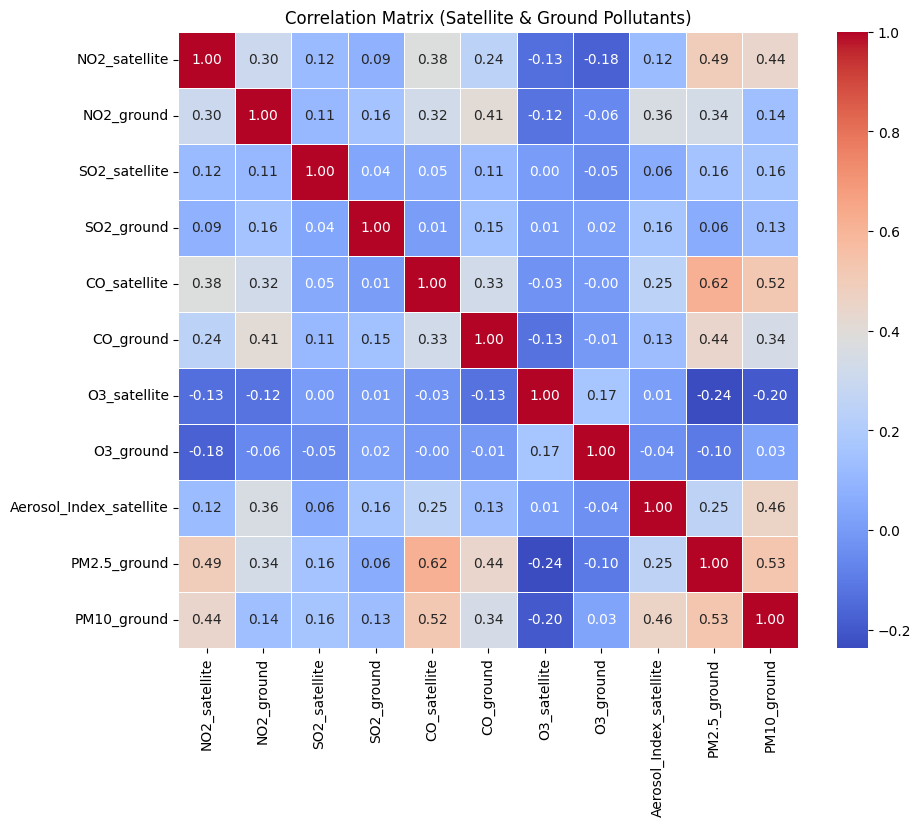

In [16]:
# Plot a heatmap of the full correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix (Satellite & Ground Pollutants)')
plt.show()


--- Scatter Plots (Satellite vs. Ground) ---


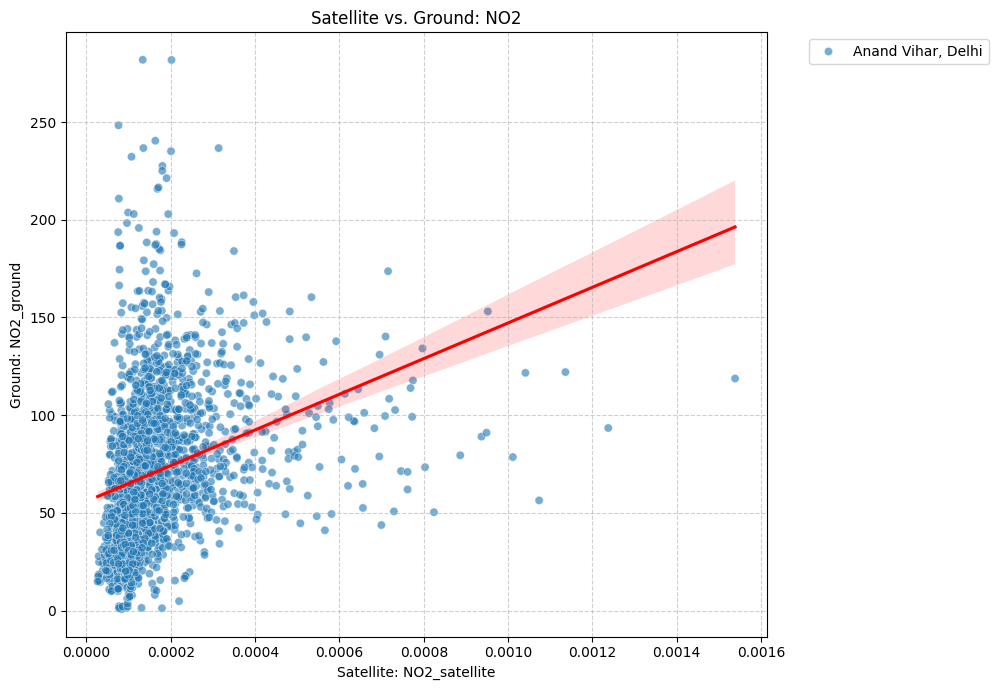

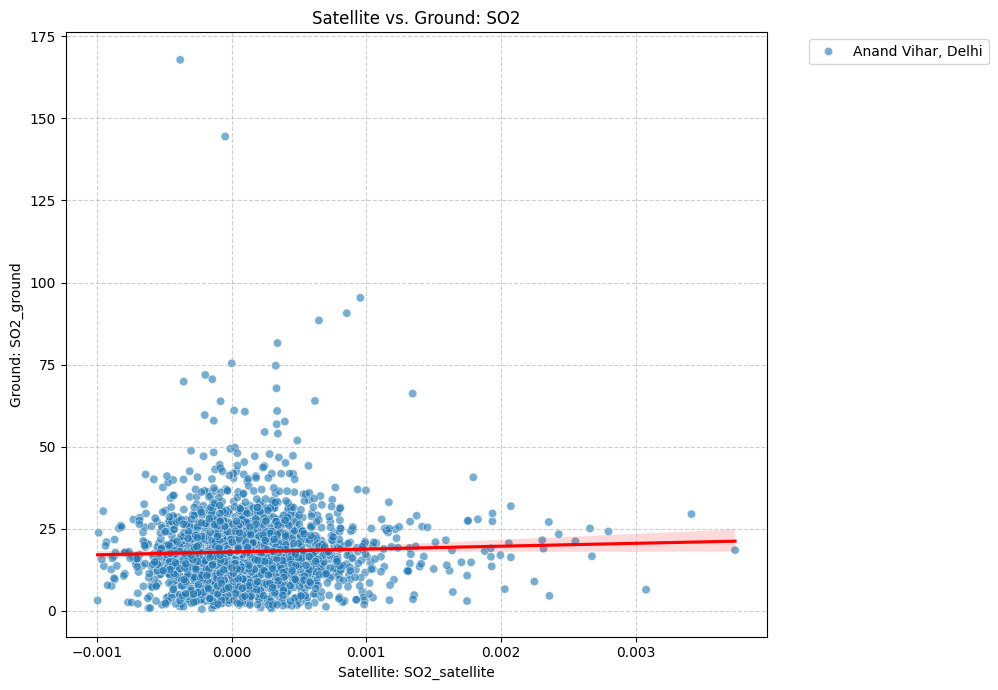

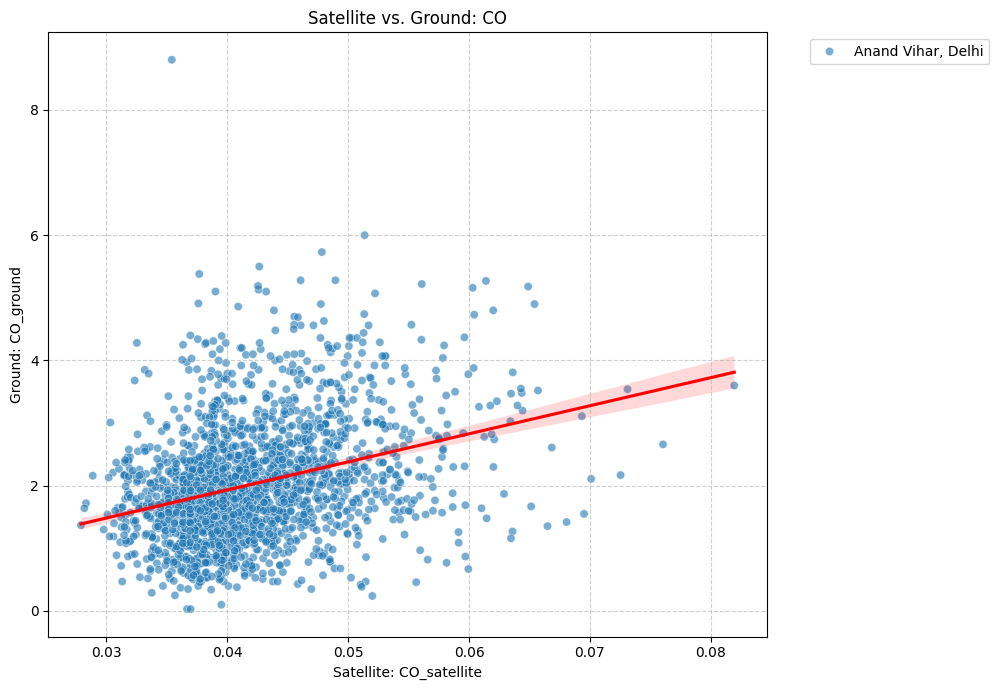

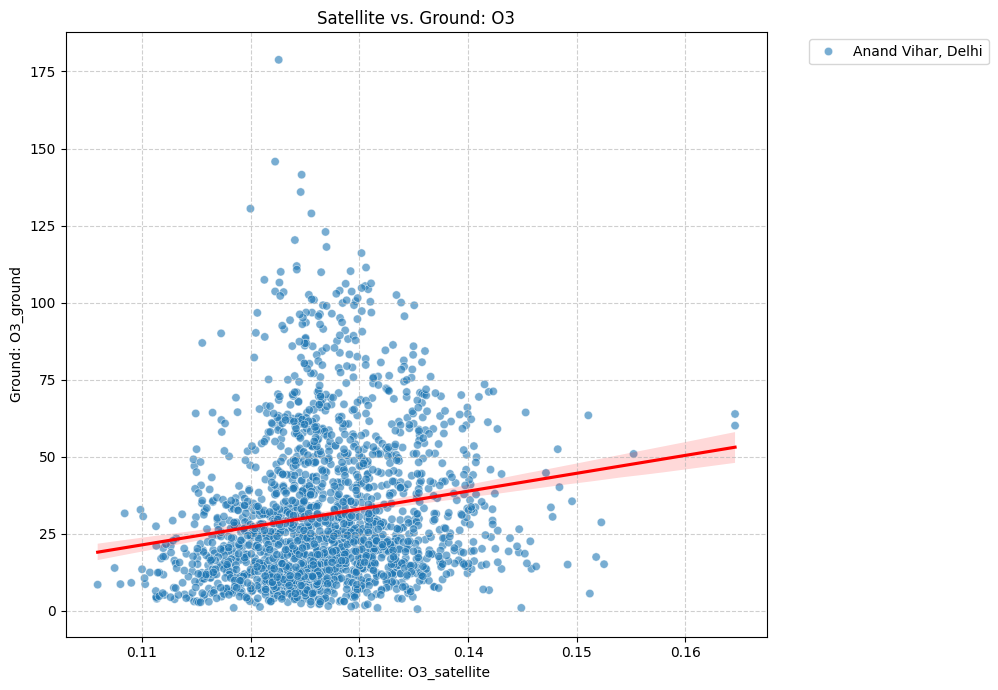

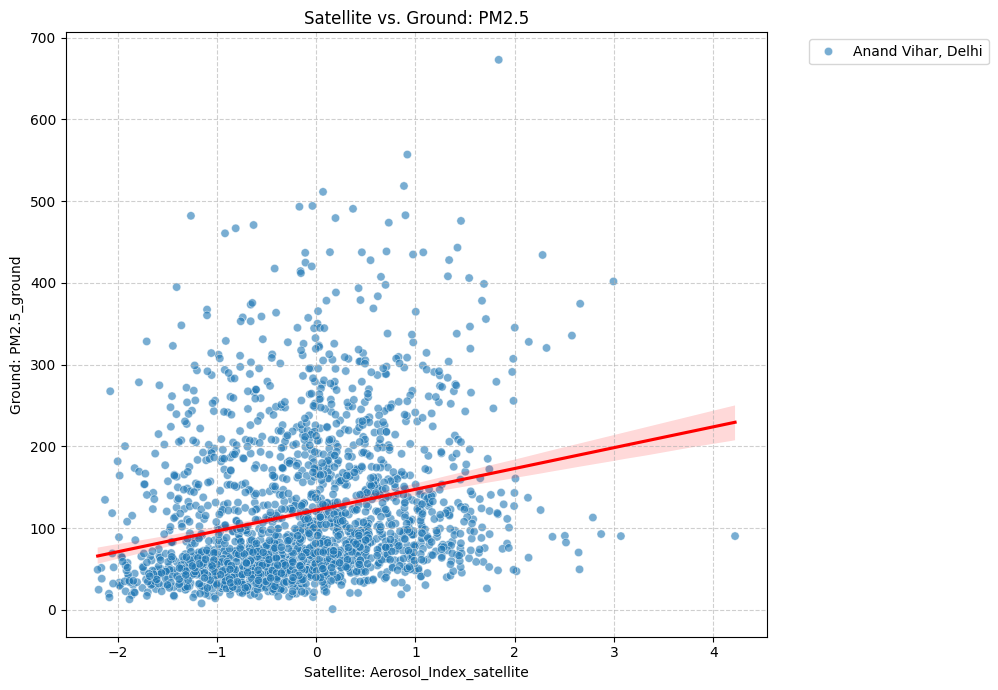

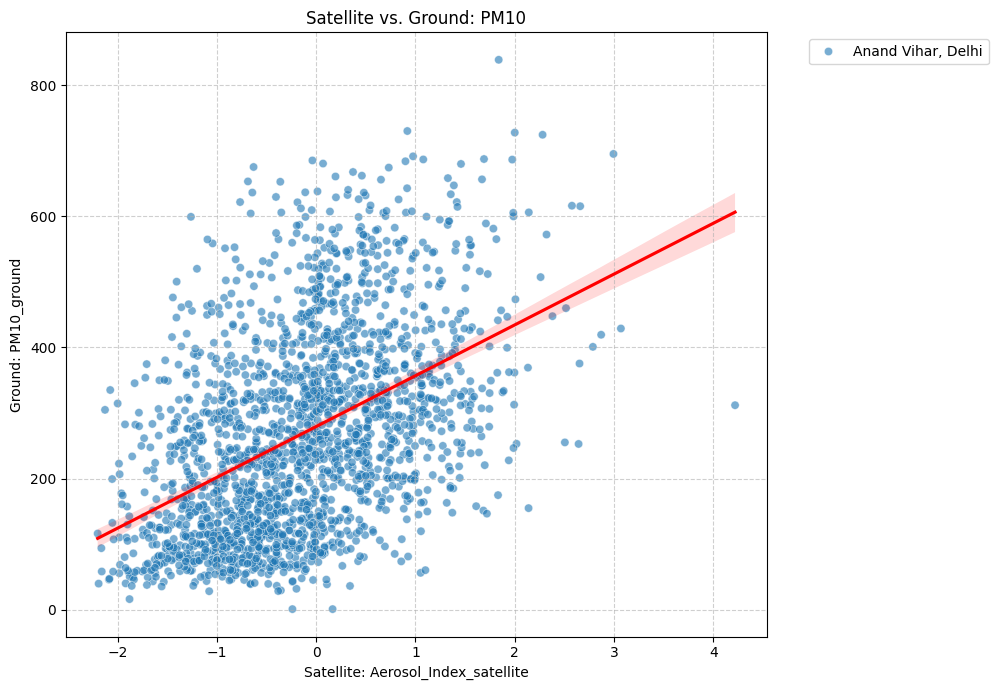

In [18]:
print("\n--- Scatter Plots (Satellite vs. Ground) ---")

for pollutant, (sat_col, gnd_col) in comparison_pairs.items():
    # Drop rows where *this specific pair* has missing data
    plot_df = master_df[[sat_col, gnd_col, 'location']].dropna()

    if plot_df.empty:
        print(f"Skipping {pollutant} plot: No overlapping data found.")
        continue

    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=plot_df, x=sat_col, y=gnd_col, hue='location', alpha=0.6)
    
    # Add a correlation line (regression line)
    sns.regplot(data=plot_df, x=sat_col, y=gnd_col, scatter=False, color='red')
    
    plt.title(f'Satellite vs. Ground: {pollutant}')
    plt.xlabel(f'Satellite: {sat_col}')
    plt.ylabel(f'Ground: {gnd_col}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [19]:
print("\n--- Generating Time Series Trend Comparison Plots ---")

# Get unique locations from the master dataframe
locations_to_plot = master_df['location'].unique()


--- Generating Time Series Trend Comparison Plots ---



--- Plotting for Pollutant: NO2 ---


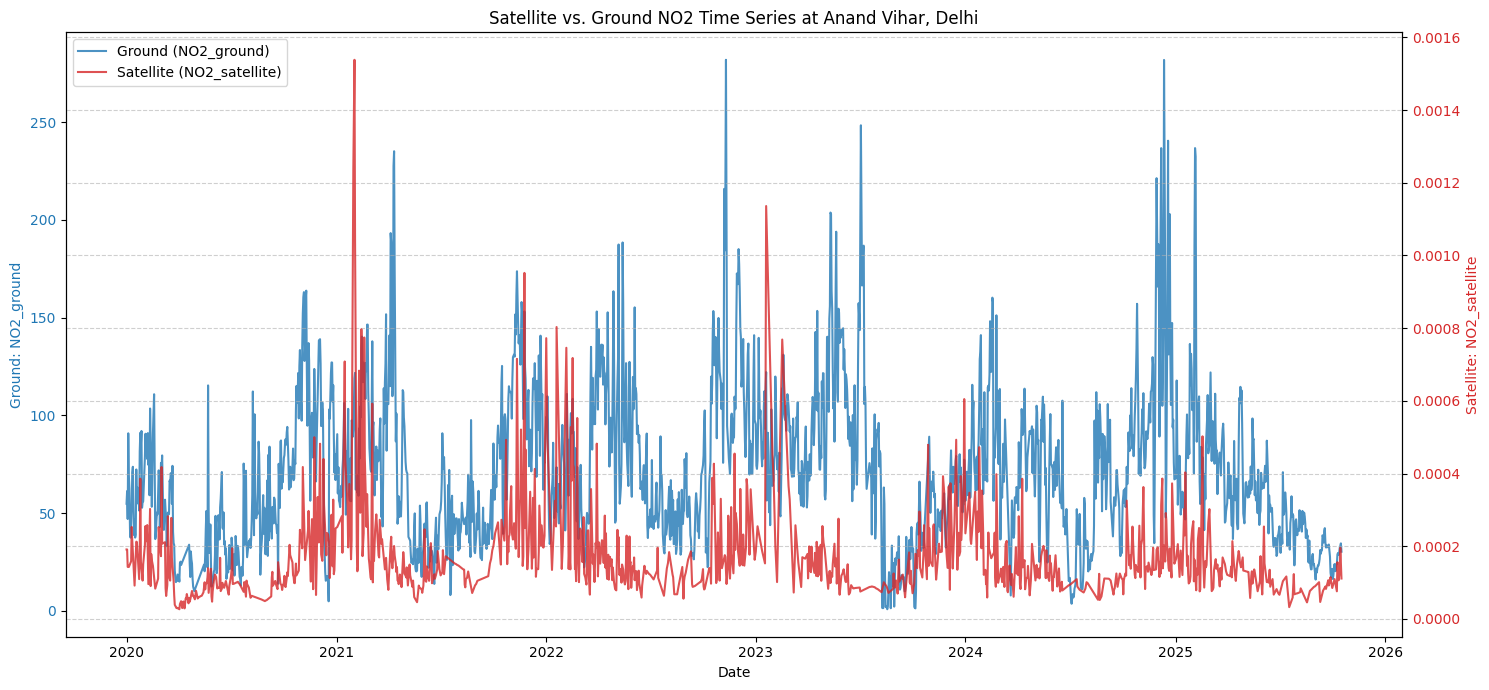

Skipping Mandir Marg  Delhi - DPCC  for NO2: No overlapping data.
Skipping Mandir Marg, Delhi for NO2: No overlapping data.
Skipping Punjabi Bagh  Delhi - DPCC  for NO2: No overlapping data.
Skipping Punjabi Bagh, Delhi for NO2: No overlapping data.
Skipping R K Puram  Delhi - DPCC  for NO2: No overlapping data.
Skipping RK Puram, Delhi for NO2: No overlapping data.
Skipping Sector - 125  Noida - UPPCB  for NO2: No overlapping data.
Skipping Sector 125, Noida for NO2: No overlapping data.
Skipping Sector 51, Gurugram for NO2: No overlapping data.
Skipping Sector 62, Noida for NO2: No overlapping data.
Skipping Sector-51  Gurugram - HSPCB  for NO2: No overlapping data.
Skipping Vikas Sadan  Gurugram - HSPCB  for NO2: No overlapping data.
Skipping Vikas Sadan, Gurugram for NO2: No overlapping data.

--- Plotting for Pollutant: SO2 ---


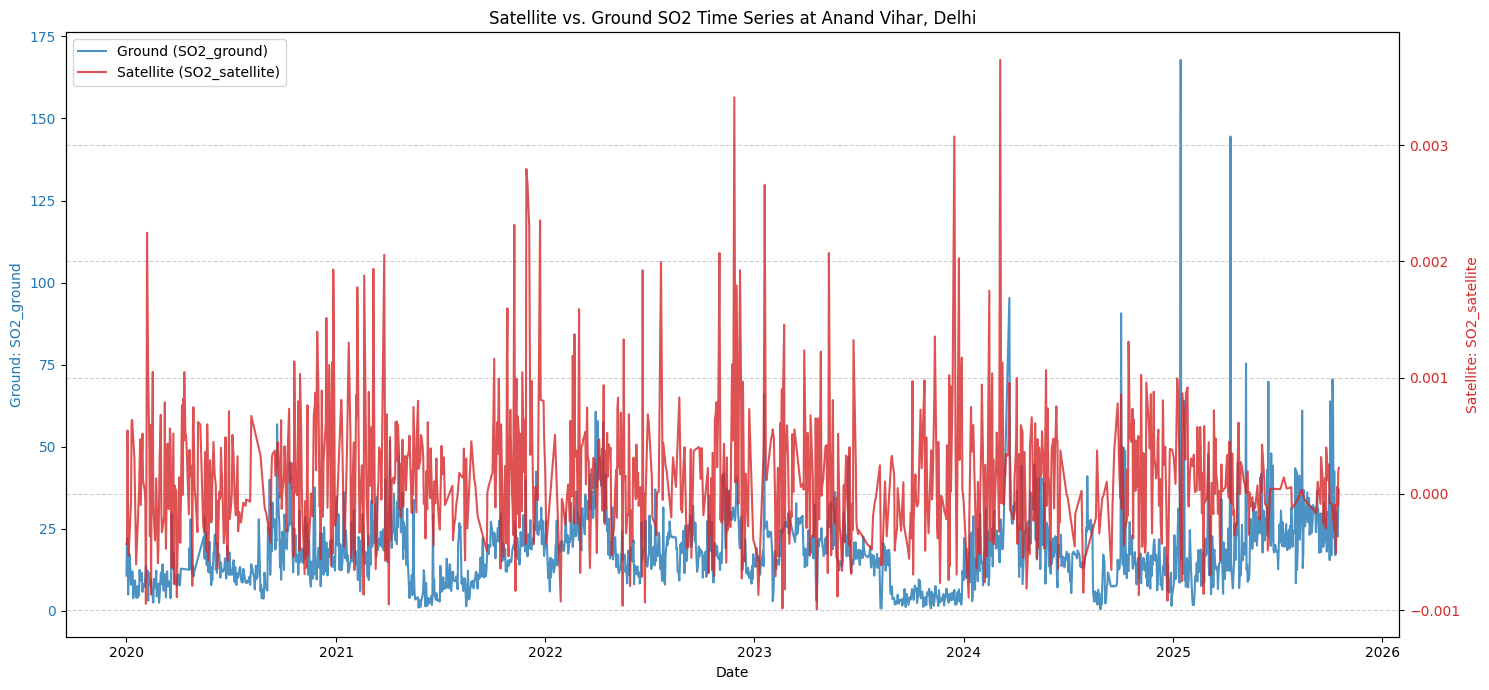

Skipping Mandir Marg  Delhi - DPCC  for SO2: No overlapping data.
Skipping Mandir Marg, Delhi for SO2: No overlapping data.
Skipping Punjabi Bagh  Delhi - DPCC  for SO2: No overlapping data.
Skipping Punjabi Bagh, Delhi for SO2: No overlapping data.
Skipping R K Puram  Delhi - DPCC  for SO2: No overlapping data.
Skipping RK Puram, Delhi for SO2: No overlapping data.
Skipping Sector - 125  Noida - UPPCB  for SO2: No overlapping data.
Skipping Sector 125, Noida for SO2: No overlapping data.
Skipping Sector 51, Gurugram for SO2: No overlapping data.
Skipping Sector 62, Noida for SO2: No overlapping data.
Skipping Sector-51  Gurugram - HSPCB  for SO2: No overlapping data.
Skipping Vikas Sadan  Gurugram - HSPCB  for SO2: No overlapping data.
Skipping Vikas Sadan, Gurugram for SO2: No overlapping data.

--- Plotting for Pollutant: CO ---


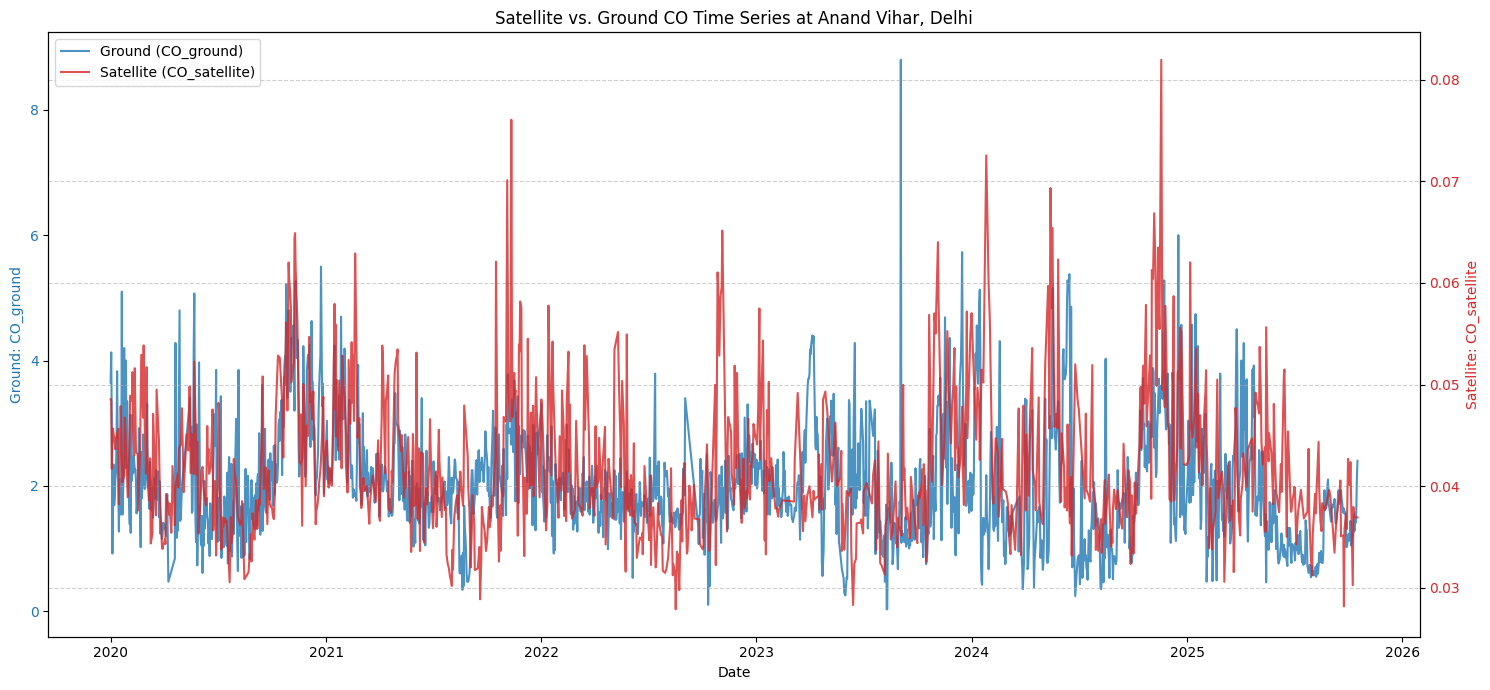

Skipping Mandir Marg  Delhi - DPCC  for CO: No overlapping data.
Skipping Mandir Marg, Delhi for CO: No overlapping data.
Skipping Punjabi Bagh  Delhi - DPCC  for CO: No overlapping data.
Skipping Punjabi Bagh, Delhi for CO: No overlapping data.
Skipping R K Puram  Delhi - DPCC  for CO: No overlapping data.
Skipping RK Puram, Delhi for CO: No overlapping data.
Skipping Sector - 125  Noida - UPPCB  for CO: No overlapping data.
Skipping Sector 125, Noida for CO: No overlapping data.
Skipping Sector 51, Gurugram for CO: No overlapping data.
Skipping Sector 62, Noida for CO: No overlapping data.
Skipping Sector-51  Gurugram - HSPCB  for CO: No overlapping data.
Skipping Vikas Sadan  Gurugram - HSPCB  for CO: No overlapping data.
Skipping Vikas Sadan, Gurugram for CO: No overlapping data.

--- Plotting for Pollutant: O3 ---


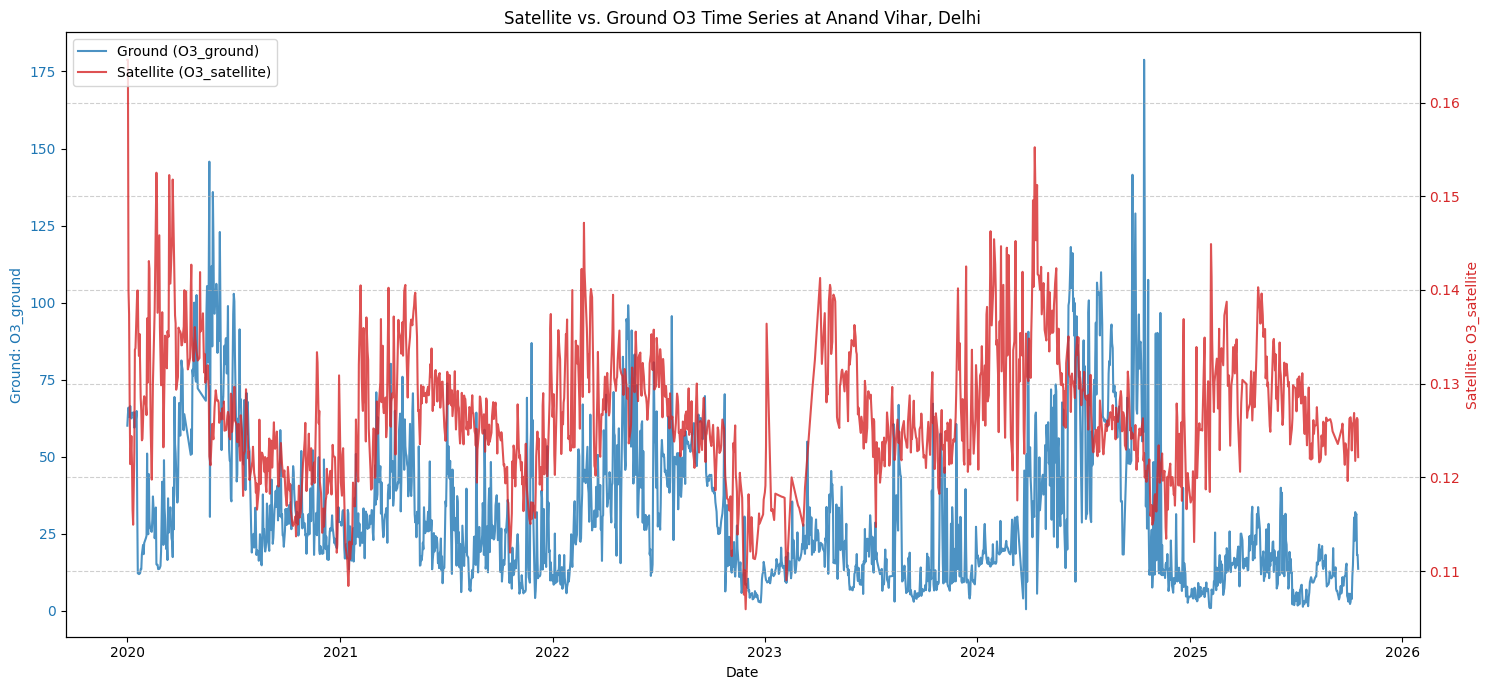

Skipping Mandir Marg  Delhi - DPCC  for O3: No overlapping data.
Skipping Mandir Marg, Delhi for O3: No overlapping data.
Skipping Punjabi Bagh  Delhi - DPCC  for O3: No overlapping data.
Skipping Punjabi Bagh, Delhi for O3: No overlapping data.
Skipping R K Puram  Delhi - DPCC  for O3: No overlapping data.
Skipping RK Puram, Delhi for O3: No overlapping data.
Skipping Sector - 125  Noida - UPPCB  for O3: No overlapping data.
Skipping Sector 125, Noida for O3: No overlapping data.
Skipping Sector 51, Gurugram for O3: No overlapping data.
Skipping Sector 62, Noida for O3: No overlapping data.
Skipping Sector-51  Gurugram - HSPCB  for O3: No overlapping data.
Skipping Vikas Sadan  Gurugram - HSPCB  for O3: No overlapping data.
Skipping Vikas Sadan, Gurugram for O3: No overlapping data.

--- Plotting for Pollutant: PM2.5 ---


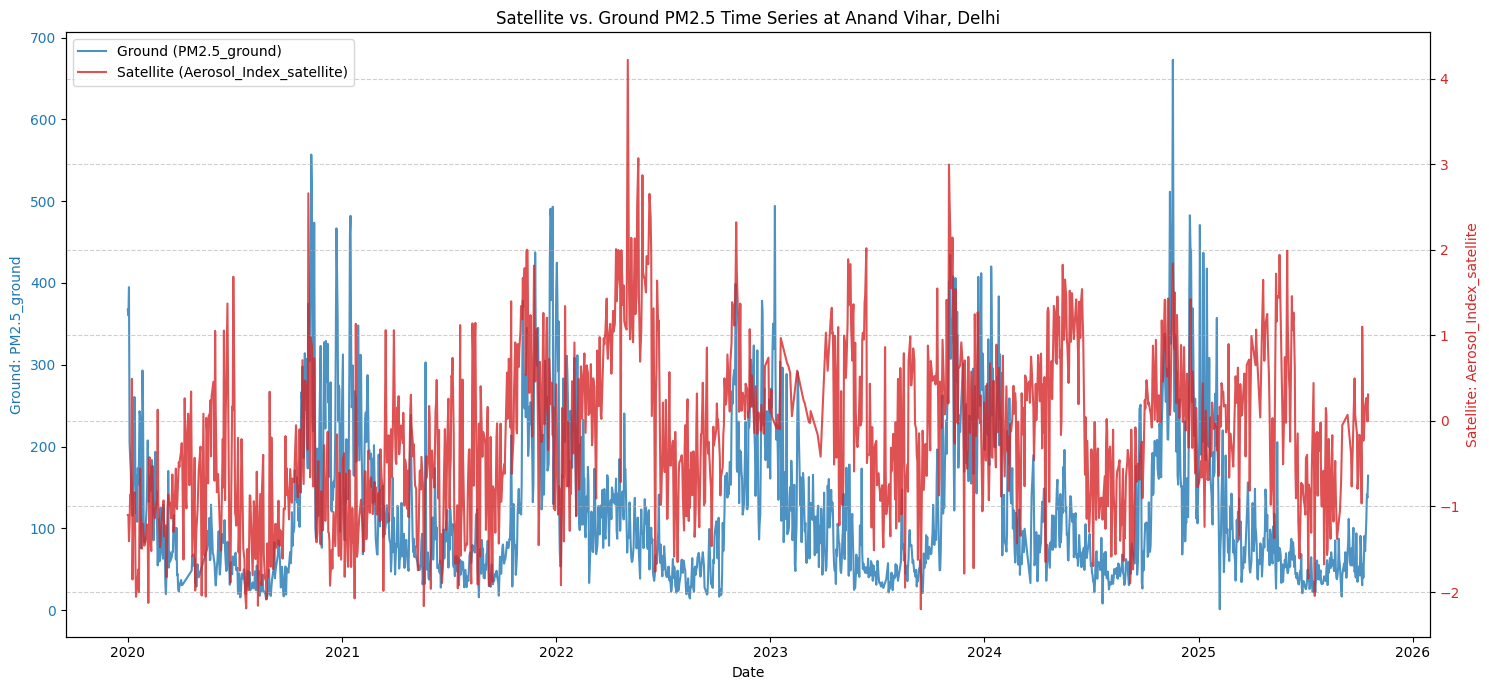

Skipping Mandir Marg  Delhi - DPCC  for PM2.5: No overlapping data.
Skipping Mandir Marg, Delhi for PM2.5: No overlapping data.
Skipping Punjabi Bagh  Delhi - DPCC  for PM2.5: No overlapping data.
Skipping Punjabi Bagh, Delhi for PM2.5: No overlapping data.
Skipping R K Puram  Delhi - DPCC  for PM2.5: No overlapping data.
Skipping RK Puram, Delhi for PM2.5: No overlapping data.
Skipping Sector - 125  Noida - UPPCB  for PM2.5: No overlapping data.
Skipping Sector 125, Noida for PM2.5: No overlapping data.
Skipping Sector 51, Gurugram for PM2.5: No overlapping data.
Skipping Sector 62, Noida for PM2.5: No overlapping data.
Skipping Sector-51  Gurugram - HSPCB  for PM2.5: No overlapping data.
Skipping Vikas Sadan  Gurugram - HSPCB  for PM2.5: No overlapping data.
Skipping Vikas Sadan, Gurugram for PM2.5: No overlapping data.

--- Plotting for Pollutant: PM10 ---


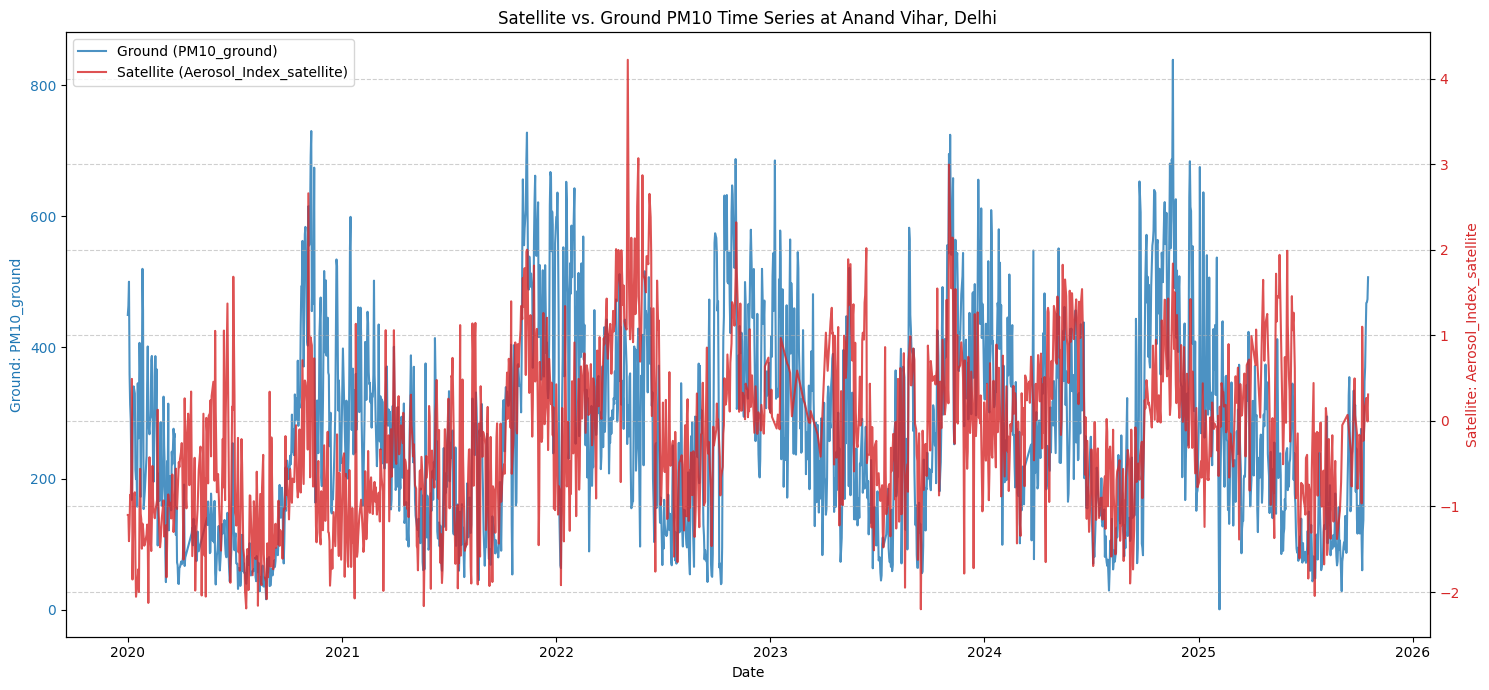

Skipping Mandir Marg  Delhi - DPCC  for PM10: No overlapping data.
Skipping Mandir Marg, Delhi for PM10: No overlapping data.
Skipping Punjabi Bagh  Delhi - DPCC  for PM10: No overlapping data.
Skipping Punjabi Bagh, Delhi for PM10: No overlapping data.
Skipping R K Puram  Delhi - DPCC  for PM10: No overlapping data.
Skipping RK Puram, Delhi for PM10: No overlapping data.
Skipping Sector - 125  Noida - UPPCB  for PM10: No overlapping data.
Skipping Sector 125, Noida for PM10: No overlapping data.
Skipping Sector 51, Gurugram for PM10: No overlapping data.
Skipping Sector 62, Noida for PM10: No overlapping data.
Skipping Sector-51  Gurugram - HSPCB  for PM10: No overlapping data.
Skipping Vikas Sadan  Gurugram - HSPCB  for PM10: No overlapping data.
Skipping Vikas Sadan, Gurugram for PM10: No overlapping data.

--- All Time Series Plots Generated ---


In [20]:
# Loop through each pollutant pair
for pollutant, (sat_col, gnd_col) in comparison_pairs.items():
    
    print(f"\n--- Plotting for Pollutant: {pollutant} ---")

    # Loop through each location
    for location in locations_to_plot:
        
        # Select data for the current location
        ts_df = master_df[master_df['location'] == location].copy()
        
        # Check if this location has the columns we need
        if not all(col in ts_df.columns for col in [sat_col, gnd_col]):
            print(f"Skipping {location} for {pollutant}: Columns missing.")
            continue
            
        # Drop days where *either* measurement is missing for this plot
        ts_df.dropna(subset=[sat_col, gnd_col], inplace=True)
        
        if ts_df.empty:
            print(f"Skipping {location} for {pollutant}: No overlapping data.")
            continue
        
        # --- Start Plotting for this combination ---
        fig, ax1 = plt.subplots(figsize=(15, 7))

        # Plot 1: Ground Pollutant on the left y-axis (ax1)
        color1 = 'tab:blue'
        ax1.set_xlabel('Date')
        ax1.set_ylabel(f'Ground: {gnd_col}', color=color1)
        ax1.plot(ts_df['date'], ts_df[gnd_col], color=color1, label=f'Ground ({gnd_col})', alpha=0.8)
        ax1.tick_params(axis='y', labelcolor=color1)
        
        # Create a second y-axis (ax2) that shares the same x-axis
        ax2 = ax1.twinx()
        
        # Plot 2: Satellite Pollutant on the right y-axis (ax2)
        color2 = 'tab:red'
        ax2.set_ylabel(f'Satellite: {sat_col}', color=color2)
        ax2.plot(ts_df['date'], ts_df[sat_col], color=color2, label=f'Satellite ({sat_col})', alpha=0.8)
        ax2.tick_params(axis='y', labelcolor=color2)
        
        # Add legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.title(f'Satellite vs. Ground {pollutant} Time Series at {location}')
        fig.tight_layout() # Adjust plot to prevent overlap
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        # --- End Plotting ---

print("\n--- All Time Series Plots Generated ---")